In [1]:

import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
  

import torch.nn.functional as F
from torchvision import datasets, transforms
from  torch import optim 
from torchvision import transforms, utils, models
from collections import OrderedDict
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
import PIL
import pandas as pd
import seaborn as sns
import os
import pickle
import random
from skimage import io
from tqdm import tqdm, tqdm_notebook, trange
from PIL import Image
from pathlib import Path
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import time
from matplotlib import colors, pyplot as plt
%matplotlib inline
from torch.optim import lr_scheduler
import copy
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

CUDA is available!  Training on GPU ...


In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [3]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [4]:
from torchvision.transforms.transforms import CenterCrop
data_dir = '/content/gdrive/MyDrive/Snake Images/'

data_transforms = {
    'train': transforms.Compose([
                                transforms.Resize((224,224)),
                                transforms.RandomRotation(35),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}
# специальный класс для загрузки данных в виде батчей
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                              shuffle=True, num_workers=4)
               for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}

use_gpu = torch.cuda.is_available()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [5]:
print(len(dataloaders['test']))
print(len(dataloaders['train']))
print(dataset_sizes)

28
102
{'train': 1630, 'test': 439}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


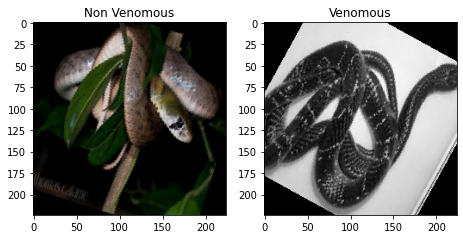

In [6]:
def image_convert(img):
    img = img.clone().cpu().numpy()
    img = img.transpose(1,2,0)
    std = [0.229, 0.224, 0.225]
    mean = [0.485, 0.456, 0.406]
    img = img*std + mean
    return img

def plot_2():
        iter_ = iter(dataloaders['train'])
        images,labels = next(iter_)
        an_ = {'0':'Non Venomous','1':'Venomous'}
        
        plt.figure(figsize=(20,10))
        for idx in range(2):
            plt.subplot(2,5,idx+1)
            img = image_convert(images[idx])
            label = labels[idx]
            plt.imshow(img)
            plt.title(an_[str(label.numpy())])
        plt.show()

plot_2()

In [7]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0
    losses = {'train': [], "test": []}
    acc = {'train': [], "test": []}

    pbar = trange(num_epochs, desc="Epoch:")
    for epoch in pbar:
        for phase in ['train', 'test']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for data in tqdm(dataloaders[phase], leave=False, desc=f"{phase} iter:"):
                inputs, labels = data
                if use_gpu:
                    inputs = inputs.cuda()
                    labels = labels.cuda()
                else:
                    inputs, labels = inputs, labels

                if phase=="train":
                    optimizer.zero_grad()
                if phase == "test":
                    with torch.no_grad():
                        outputs = model(inputs)
                else:
                    outputs = model(inputs)
                preds = torch.argmax(outputs, -1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                running_loss += loss.item()
                running_corrects += int(torch.sum(preds == labels.data))

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            acc[phase].append(epoch_acc)
            losses[phase].append(epoch_loss)
            
            pbar.set_description('{} Loss: {:.4f} Acc: {:.4f}'.format(
                                    phase, epoch_loss, epoch_acc))

            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Лучшая точность: {:4f}'.format(best_acc))

    # загрузим лучшие веса модели
    model.load_state_dict(best_model_wts)
    return model, losses, acc, best_acc, best_model_wts

In [8]:
def stat(model):
  confusion_matrix = torch.zeros(2, 2)
  with torch.no_grad():
      for i, (inputs, classes) in enumerate(dataloaders['test']):
          inputs = inputs.to(device)
          classes = classes.to(device)
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          for t, p in zip(classes.view(-1), preds.view(-1)):
                  confusion_matrix[t.long(), p.long()] += 1

  print(confusion_matrix)

  print(confusion_matrix.diag()/confusion_matrix.sum(1))
  return(confusion_matrix)


In [ ]:
model =  models.resnet152(pretrained=True).to(device)

In [ ]:
class Dc_model(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1=nn.Linear(2048, 950)
        self.linear2=nn.Linear(950, 512)
        self.linear3=nn.Linear(512, 2)

    def forward(self,x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x

model_ = Dc_model().to(device)
model.fc = model_
print(model)

for param in model.parameters():
        param.requires_grad = False
for param in model.fc.parameters():
        param.requires_grad = True


In [11]:
# Использовать ли GPU
if use_gpu:
    model = model.cuda()

loss_fn = nn.CrossEntropyLoss()

optimizer_ft = optim.Adam(model.parameters(), lr=0.001)
#optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model, losses, acc, best_acc, best_model_wts = train_model(model, loss_fn, optimizer_ft, exp_lr_scheduler, num_epochs=30)

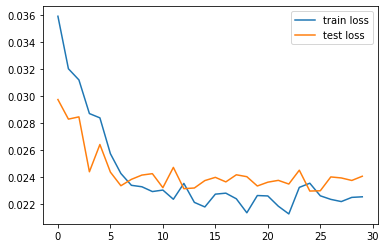

In [13]:
plt.plot(losses['train'],label='train loss')
plt.plot(losses['test'],label='test loss')
plt.legend()
plt.show()

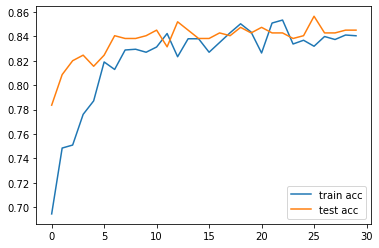

In [14]:
plt.plot(acc['train'],label='train acc')
plt.plot(acc['test'],label='test acc')
plt.legend()
plt.show()

In [15]:
torch.save(model.state_dict(), 'resnet950_512.pth')
model.load_state_dict(torch.load('resnet950_512.pth'))

<All keys matched successfully>

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


tensor([[174.,  38.],
        [ 25., 202.]])
tensor([0.8208, 0.8899])


''

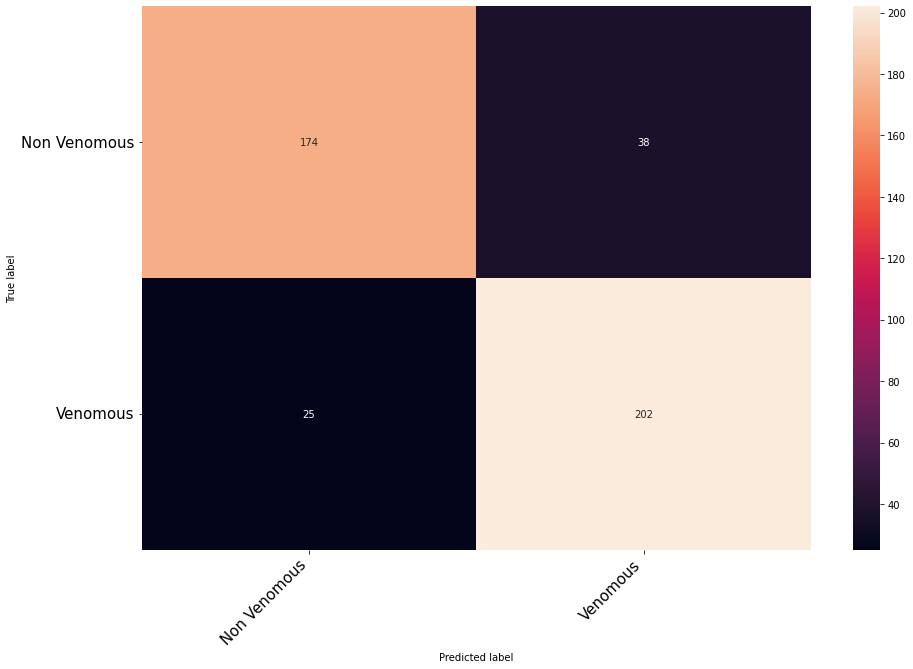

In [19]:
x = stat(model)
plt.figure(figsize=(15,10))

class_names = list(['Non Venomous','Venomous'])
df_cm = pd.DataFrame(x, index=class_names, columns=class_names).astype(int)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
;

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integ

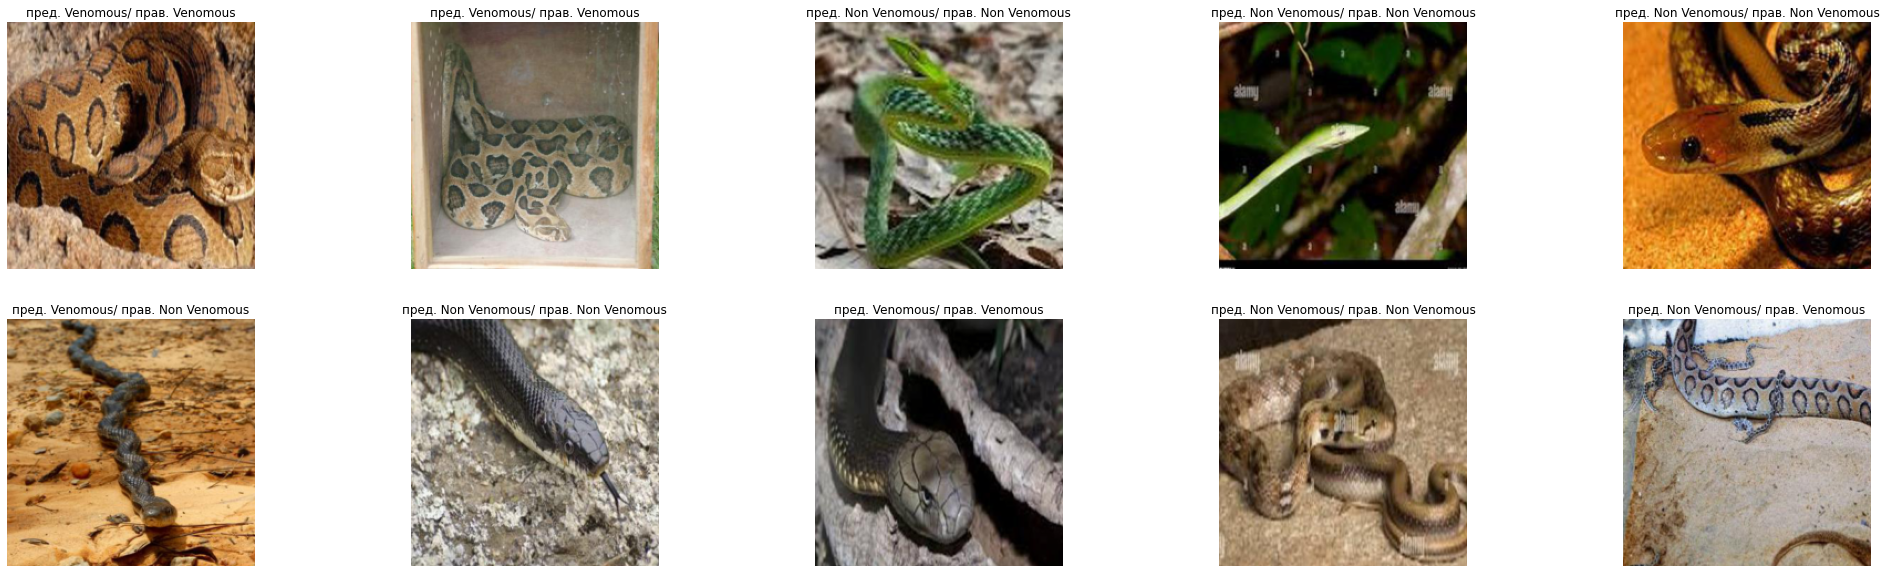

In [18]:
def visualize_model(model, num_images=10):
    model.eval()
    images_handeled = 0
    fig = plt.figure(figsize=(35,10))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_handeled += 1
                ax = plt.subplot(2,5,j+1)

                ax.axis('off')
                ax.set_title('пред. {}/ прав. {}'.format(class_names[preds[j]], class_names[labels[j]]))

                plt.imshow(image_convert(inputs.data[j]))
                

                if images_handeled == num_images:
                    return
visualize_model(model)